## Import libraries and dependencies


In [1]:
import optimiseprime.data_prep as dp
import optimiseprime.data_analysis as da


import datetime as dt

import pandas as pd
import yfinance as yf
import quantstats as qs
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import plotly.graph_objs as go                    #create candlestick charts  
import plotly.express as px                       #create Violin plots, pie charts, box plot, scatter plots,line graph, area

import plotly.io as pio
pio.renderers.default ='colab'                   #Initializing plotly

qs.extend_pandas()

## Request user for portfolio details, and fetch price data from yfinance Yahoo! Finance API

In [2]:
portfolio_choice = 0

while portfolio_choice not in [1, 2]:
    try:
        portfolio_choice = int(input(         
            "To analyse an existing portfolio, type 1\n"
            "To analyse a hypothetical portfolio, type 2\n"
        )
                              )
    # Print error message if type(portfolio_choice) != int                        
    except ValueError:
        print('Error: Invalid response.\n')
        
    # Print error message if portfolio choice not 1 or 2
    if portfolio_choice not in [1, 2]:
        print('Error: Invalid response.\n')

# Get portfolio data from user depending on choice:

ticker_list = []

while len(ticker_list) == 0:
    if portfolio_choice == 1:
        existing_portfolio = dp.get_existing_portfolio()
        
        # Create a list of only the tickers
        ticker_list = []
        for key, value in existing_portfolio.items():
            ticker_list.append(key)
        ticker_list = pd.DataFrame(columns=ticker_list).add_suffix('-USD').columns.tolist()
        
    elif portfolio_choice == 2:
        ticker_list = dp.get_hypothetical_portfolio()
        # Request investment amount from user
        portfolio_value = dp.get_investment_amt()
        
    if len(ticker_list) == 0:
        print("You have not entered any tickers.")
    

To analyse an existing portfolio, type 1
To analyse a hypothetical portfolio, type 2
 2


Please enter the tickers of your cryptocurrencies one by one
Type 'done' when finished.


Ticker:  BTC
Ticker:  ETH
Ticker:  done
How much do you wish to invest in total?
(Please input amount without currency symbol)
 10000


In [7]:
# Fetch data from yfinance for each ticker, and create pandas dataframe
portfolio_df = dp.get_ticker_data(ticker_list)
portfolio_df.dropna(inplace = True)



In [8]:
# Keep only tickers in ticker_list for which data is available
ticker_list = [ticker for ticker in list(portfolio_df.columns.levels[0])]

# Print portfolio data for visual confirmation
if portfolio_choice == 1:    
    # Calculate portfolio value of each cryptocurrency held
    for ticker in existing_portfolio:
        existing_portfolio[ticker].append(
            {'value': portfolio_df[f"{ticker}-USD"].iloc[-1, 3] * existing_portfolio[ticker][0]['units']})
    print(f"--------------------------")                      
    print(f"Existing Portfolio:")
    portfolio_value = 0
    for ticker, units in existing_portfolio.items():
        value = existing_portfolio[ticker][1]['value']
        print(f"Value of {existing_portfolio[ticker][0]['units']} {ticker}: ${value:.2f}")
        portfolio_value += value
    print(f"\nTotal portfolio value: ${portfolio_value:.2f}\n")       
    
elif portfolio_choice == 2:
    print(f"--------------------------")                      
    print(f"Hypothetical Portfolio:")
    print(f"{[ticker.replace('-USD', '') for ticker in ticker_list]}")                   
    print(f"Investment amount:")
    print(f"${portfolio_value:.2f}\n")

print(
    f"NOTE:\n"
    f"To achieve a fair comparison of risk-reward ratios, historical price data will be retrieved from earliest date for which ALL cryptocurrencies specified are available.\n"
    f"While this ensures fair comparison of risk-reward metrics, it may compromise accuracy of these metrics if the sample sizes of historical price data are reduced.\n"
    f"Earliest date for which price data is available for all cryptocurrencies in your portfolio: {dt.datetime.date(portfolio_df.index[0])}"
)
print(f"--------------------------")



--------------------------
Hypothetical Portfolio:
['BTC', 'ETH']
Investment amount:
$10000.00

NOTE:
To achieve a fair comparison of risk-reward ratios, historical price data will be retrieved from earliest date for which ALL cryptocurrencies specified are available.
While this ensures fair comparison of risk-reward metrics, it may compromise accuracy of these metrics if the sample sizes of historical price data are reduced.
Earliest date for which price data is available for all cryptocurrencies in your portfolio: 2019-01-15
--------------------------


## Data Analyses

### Calculate ratios:
* Sharpe ratio
* Sortino ratio
* Adjusted sortino ratio
* Gain to Pain ratio

In [9]:
# Calculate each of the following risk-reward ratio types
sharpe = da.calculate_sharpe_ratio(ticker_list, portfolio_df)
sortino =  da.calculate_sortino_ratio(ticker_list, portfolio_df)
adjusted_sortino = da.calculate_adjusted_sortino(ticker_list, portfolio_df)
gain_pain_ratio = da.calculate_gain_pain_ratio(ticker_list, portfolio_df)


# Store all ratios into a dict
ratios_df = pd.DataFrame(
    {
    'sharpe': sharpe,
    'sortino': sortino,
    'adj_sortino': adjusted_sortino,
    'gain_pain': gain_pain_ratio,
    }
)


# Calculate proportion scores for each risk-reward metric
weights = da.calculate_weights(ratios_df)



In [10]:
print(
    f"Portfolio allocation recommendations\n"
    f"Based on historical returns from {dt.datetime.date(portfolio_df.index[0])} to {dt.datetime.date(portfolio_df.index[-1])}"
)
print(f"Total portfolio value: ${portfolio_value:.2f}")
print(f"============================================================="
)

# Present all ratios in descending order

for column in ratios_df:
    if column == 'sharpe':
        da.sharpe_portfolio(ratios_df, weights, portfolio_value)
    elif column == 'sortino':
        da.sortino_portfolio(ratios_df, weights, portfolio_value)
    elif column == 'adj_sortino':
        da.adj_sortino_portfolio(ratios_df, weights, portfolio_value)
    elif column == 'gain_pain':
        da.gain_pain_portfolio(ratios_df, weights, portfolio_value)
        


Portfolio allocation recommendations
Based on historical returns from 2019-01-15 to 2022-01-13
Total portfolio value: $10000.00

Metric: Sharpe Ratio
--------------
ETH-USD                            1.64 
Recommended % of total portfolio   52.34%
Recommended value allocation       $5233.67

BTC-USD                            1.50 
Recommended % of total portfolio   47.66%
Recommended value allocation       $4766.33


Metric: Sortino Ratio
--------------
ETH-USD                            2.43 
Recommended % of total portfolio   52.13%
Recommended value allocation       $5212.57

BTC-USD                            2.23 
Recommended % of total portfolio   47.87%
Recommended value allocation       $4787.43


Metric: Adjusted Sortino Ratio
--------------
ETH-USD                            1.72 
Recommended % of total portfolio   52.12%
Recommended value allocation       $5212.50

BTC-USD                            1.58 
Recommended % of total portfolio   47.88%
Recommended value allocatio

In [13]:
display(ratios_df)

,sharpe,sortino,adj_sortino,gain_pain
BTC-USD,1.4962,2.2319,1.5782,0.2651
ETH-USD,1.6429,2.4301,1.7183,0.2836


In [14]:
display(portfolio_df)

BTC-USD                                            \
                    open          high           low         close   
Date                                                                 
2019-01-15   3704.216309   3720.153320   3619.949219   3630.675293   
2019-01-16   3631.509766   3685.777100   3624.673340   3655.006836   
2019-01-17   3651.871094   3680.135986   3621.960938   3678.563965   
2019-01-18   3677.990479   3682.520020   3637.080811   3657.839355   
2019-01-19   3652.377930   3758.533447   3652.377930   3728.568359   
...                  ...           ...           ...           ...   
2022-01-09  41734.726562  42663.949219  41338.160156  41911.601562   
2022-01-10  41910.230469  42199.484375  39796.570312  41821.261719   
2022-01-11  41819.507812  43001.156250  41407.753906  42735.855469   
2022-01-12  42742.179688  44135.367188  42528.988281  43949.101562   
2022-01-13  43966.871094  44004.589844  43513.332031  43754.785156   

                                          ETH-USD                            \
                 volume daily_return         open         high          low   
Date                                                                          
2019-01-15   5537192302    -0.020339   129.172684   130.743561   120.311523   
2019-01-16   5394457145     0.006702   121.809242   127.118248   121.441414   
2019-01-17   5464420383     0.006445   123.573540   124.270721   120.817032   
2019-01-18   5002961727    -0.005634   123.654655   123.841690   120.241898   
2019-01-19   5955691380     0.019336   121.614426   125.904228   121.161034   
...                 ...          ...          ...          ...          ...   
2022-01-09  21294384372     0.004257  3091.696289  3206.790771  3075.911377   
2022-01-10  32104232331    -0.002155  3157.570557  3177.213379  2947.683594   
2022-01-11  26327648900     0.021869  3082.990967  3247.511963  3061.140625   
2022-01-12  33499938689     0.028389  3238.449951  3401.219971  3216.718018   
2022-01-13  58777194496    -0.004421  3377.017334  3380.488037  3326.376465   

                                                   
                  close       volume daily_return  
Date                                               
2019-01-15   122.032715   2735449164    -0.054514  
2019-01-16   123.547066   2746469340     0.012409  
2019-01-17   123.741920   2594091285     0.001577  
2019-01-18   121.010262   2305389800    -0.022075  
2019-01-19   124.519020   3048261797     0.028996  
...                 ...          ...          ...  
2022-01-09  3157.751465  12334683863     0.021274  
2022-01-10  3083.097900  19535744145    -0.023641  
2022-01-11  3238.111572  15211447193     0.050279  
2022-01-12  3372.258301  16662871689     0.041427  
2022-01-13  3347.873779  16637999104    -0.007231  

[1095 rows x 12 columns]

# Visulalizations

In [15]:
btc=portfolio_df['BTC-USD']

In [16]:
eth=portfolio_df['ETH-USD']

## Pairplots

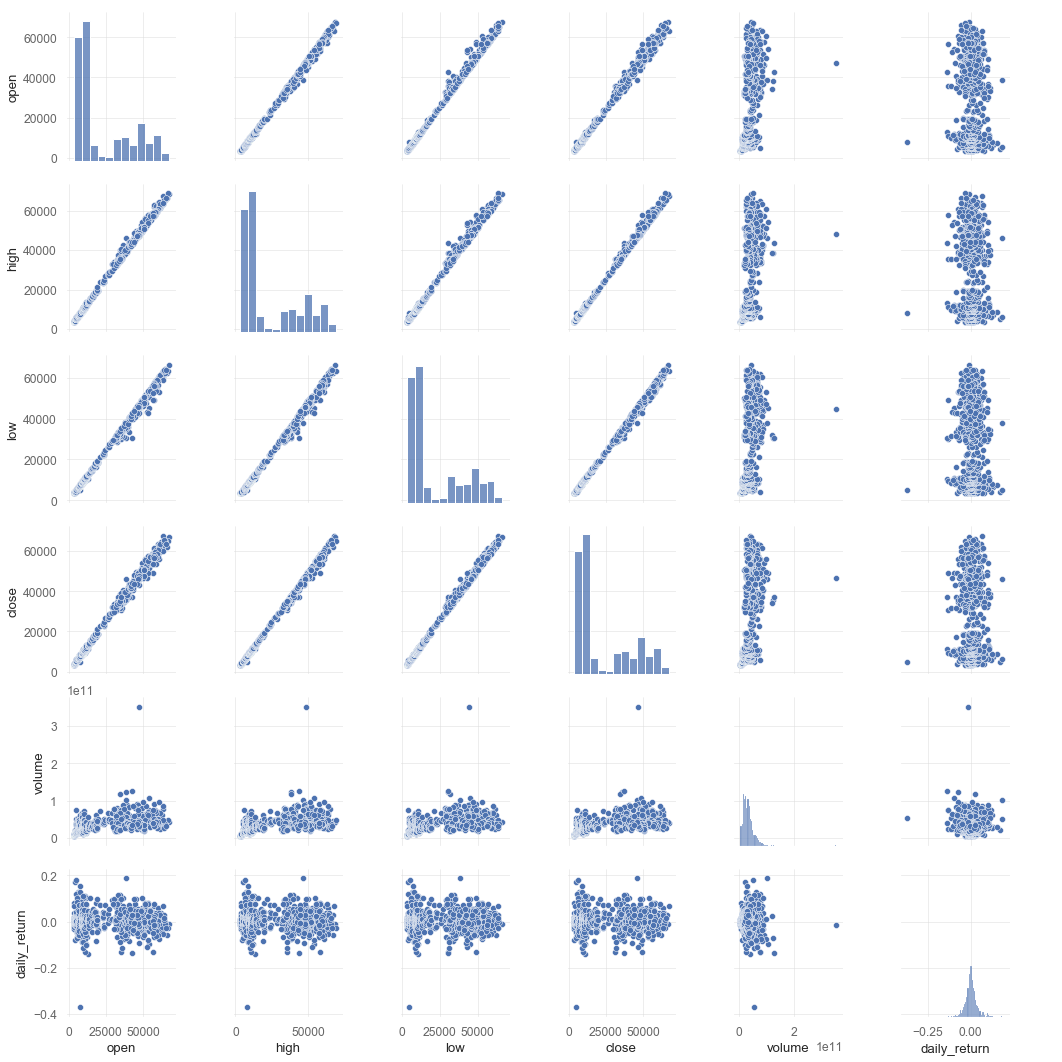

In [17]:
sns.pairplot(btc)

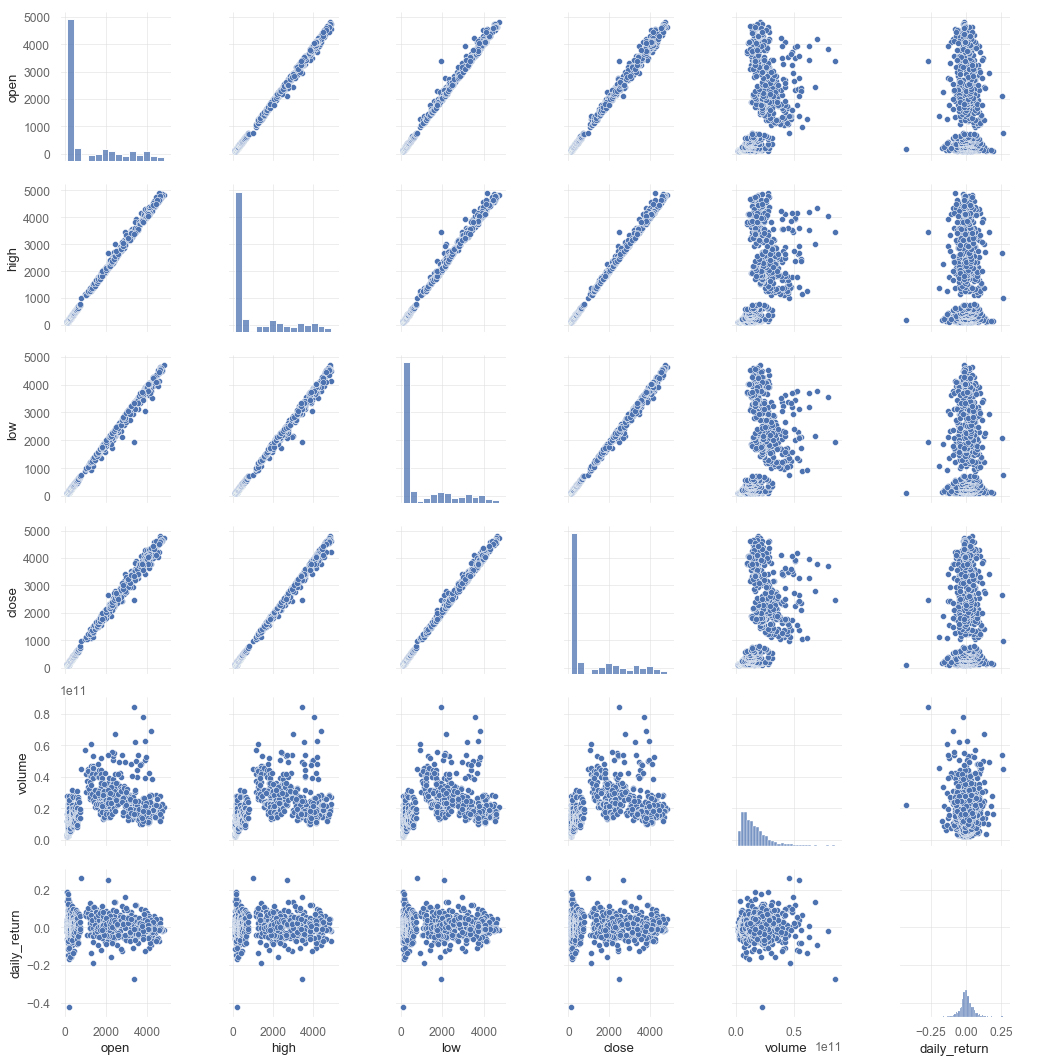

In [18]:
sns.pairplot(eth)

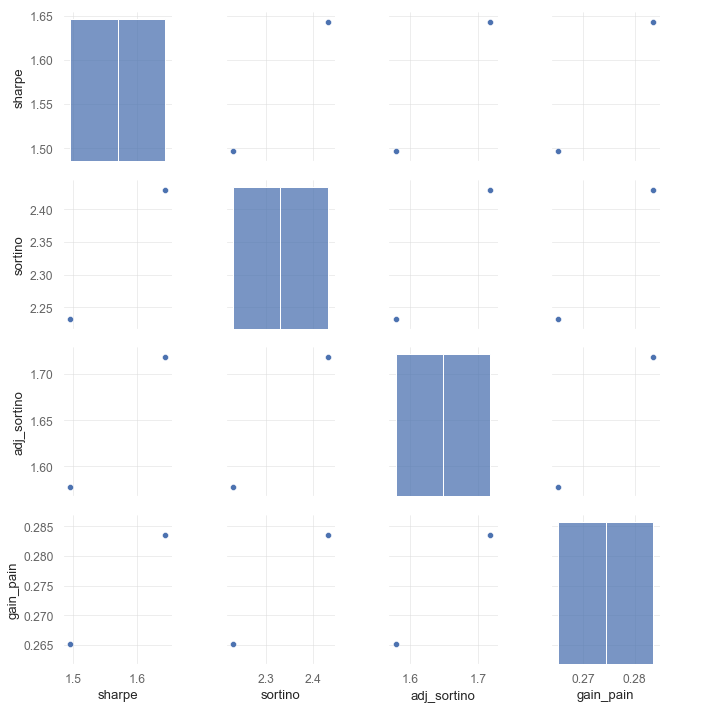

In [19]:
sns.pairplot(ratios_df)

## Line graph

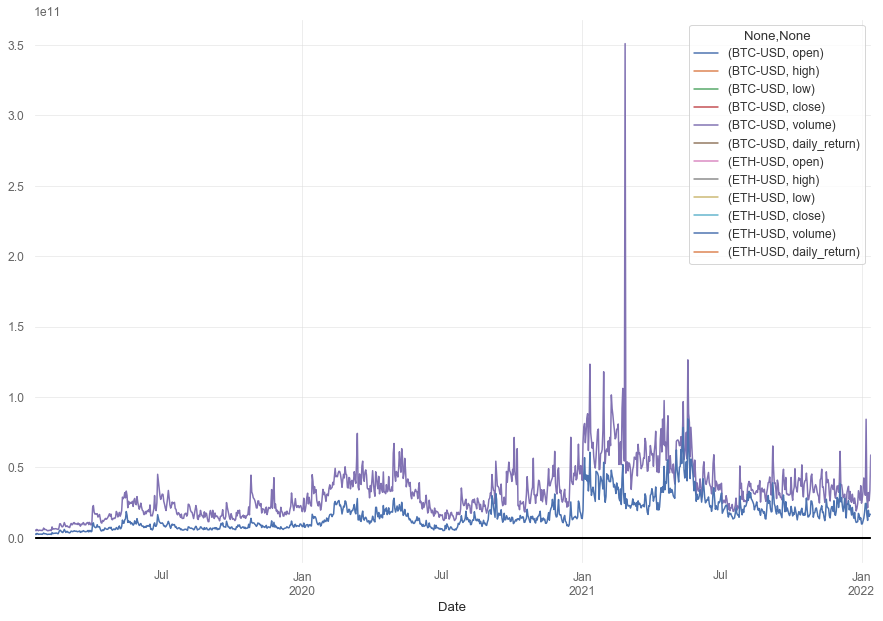

In [20]:
portfolio_df.plot(grid=True, figsize=(15, 10)).axhline(y = 1, color = "black", lw = 2)

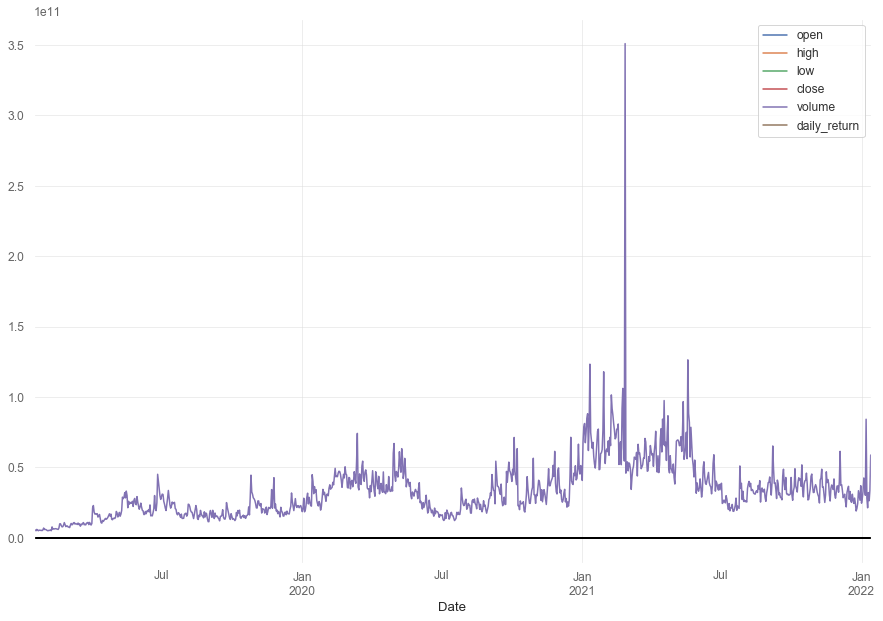

In [21]:
btc.plot(grid=True, figsize=(15, 10)).axhline(y = 1, color = "black", lw = 2)

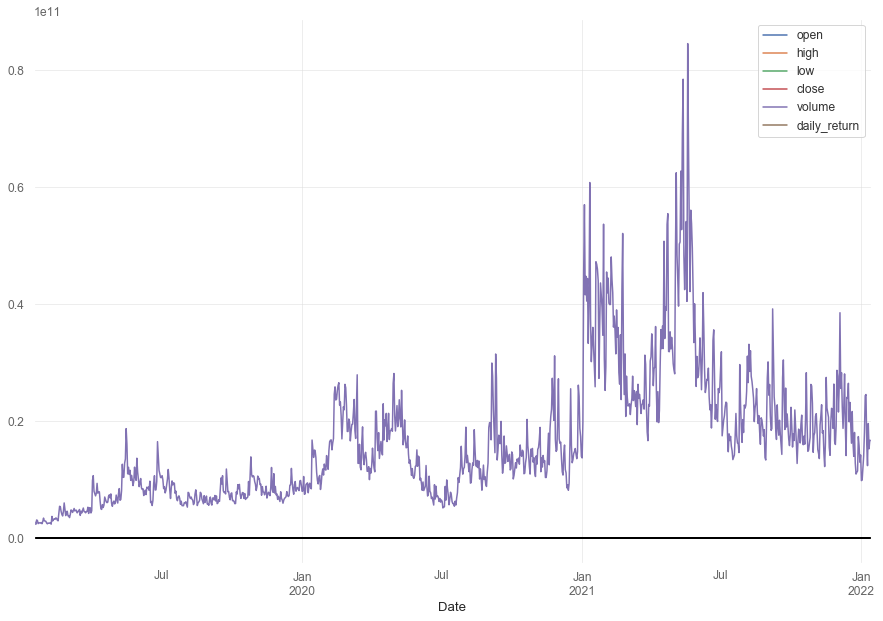

In [22]:
eth.plot(grid=True, figsize=(15, 10)).axhline(y = 1, color = "black", lw = 2)

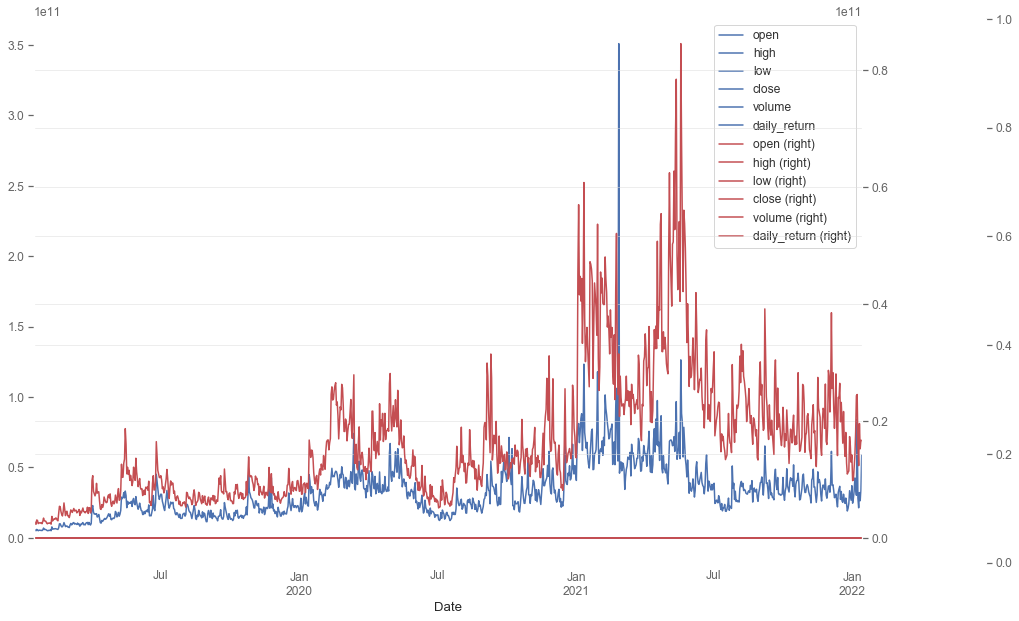

In [23]:
fig, ax1 = plt.subplots(figsize=(20, 10))
ax2 = ax1.twinx()
rspine = ax2.spines['right']
rspine.set_position(('axes', 1.15))
ax2.set_frame_on(True)
ax2.patch.set_visible(False)
fig.subplots_adjust(right=0.7)
btc.plot(ax=ax1, style='b-')
eth.plot(ax=ax1, style='r-', secondary_y=True)

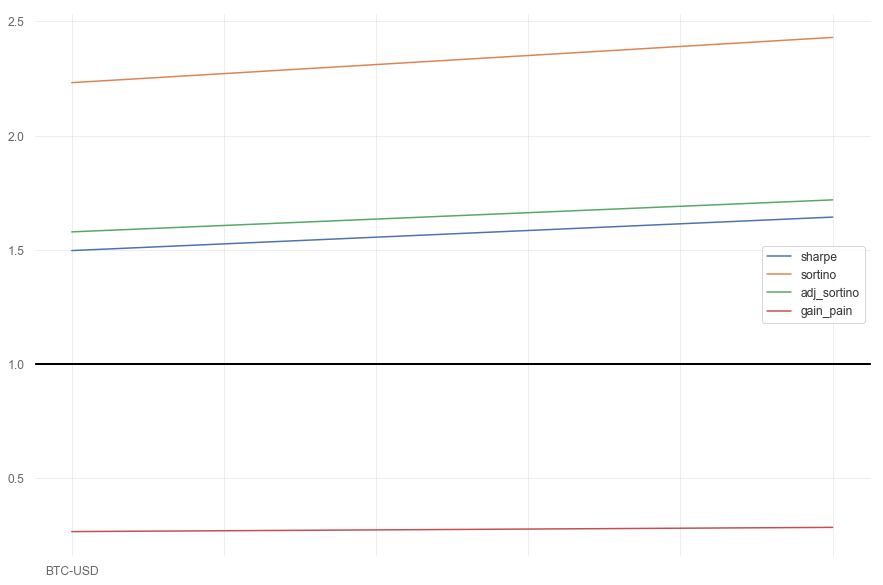

In [24]:
ratios_df.plot(grid=True, figsize=(15, 10)).axhline(y = 1, color = "black", lw = 2)

## Heatmap

In [25]:
# df2=portfolio_df.corr()
# sns.heatmap(df2,cmap="Greens", annot=True)

## Bar Graph 

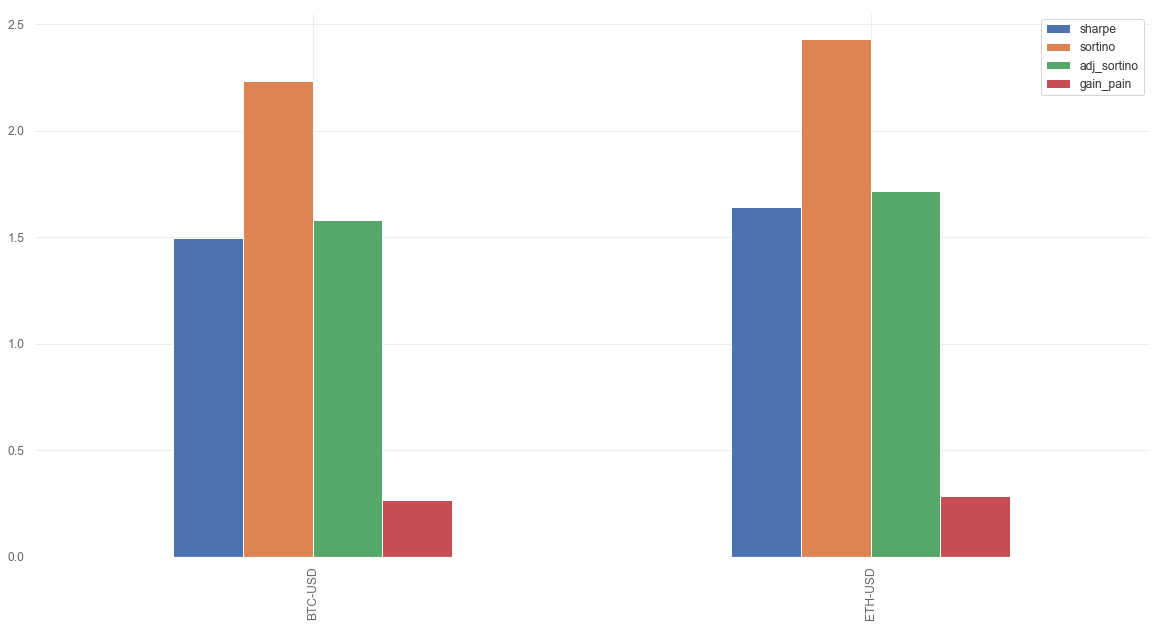

In [26]:
ratios_df.plot(kind='bar',figsize= (20,10))

## Boxplot visuliazation to find outliers

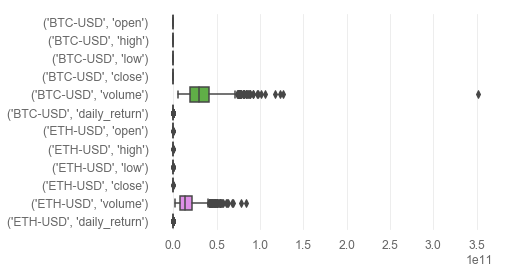

In [27]:
ax = sns.boxplot(data=portfolio_df, orient="h")

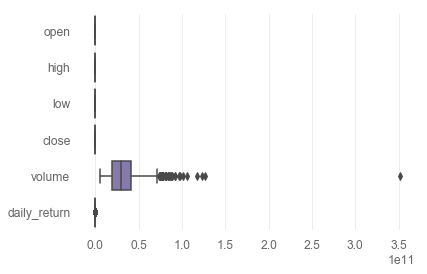

In [28]:
ax = sns.boxplot(data=btc, orient="h")

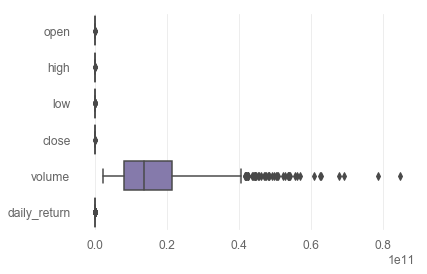

In [29]:
et = sns.boxplot(data=eth, orient="h")

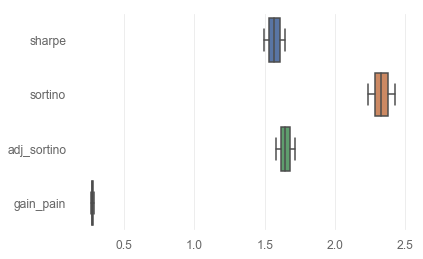

In [30]:
rd=sns.boxplot(data=ratios_df, orient="h")

## Scatter Plot

In [31]:
px.scatter(btc,hover_data = ['high','low','open','close'], height= 400)

In [48]:
px.scatter(eth, hover_data = ['high','low','open','close'], height= 400)

## Area Chart

In [49]:
px.area(btc, hover_data = ['high','low','open','close'], height= 600)

In [50]:
px.area(eth, hover_data = ['high','low','open','close'], height= 600)

## Candlestick figure

In [35]:
fig = go.Figure(data = [go.Candlestick(x=portfolio_df.index,
                       open=btc.open,
                       high=btc.high,
                       low=btc.low,
                       close=btc.close)
                                       ]) 

In [36]:
fig.show()

In [37]:
fig = go.Figure(data = [go.Candlestick(x=portfolio_df.index,
                       open=eth.open,
                       high=eth.high,
                       low=eth.low,
                       close=eth.close)
                                       ]) 

In [38]:
fig.show()

In [39]:
# import pandas as pd
# import numpy as np
# import panel as pn
# from panel.interact import interact
# from panel import widgets

In [40]:
# pn.extension()

In [41]:
# Import hvplot.pandas after pn.extension
# This avoids plotly initialization failure
# import hvplot.pandas

In [42]:
# portfolio_df.reset_index()

In [43]:
# Define function to choose a year
# def choose_Date(Date):
#     return Date

In [44]:
# Execute interact function
# interact(choose_Date, Date)

## Visualizations of Tableau

In [45]:
%%HTML
<div class='tableauPlaceholder' id='viz1641984633922' style='position: relative'><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='BarCharts1_16419846320250&#47;Multiple_Bar_Chart' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='language' value='en-GB' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1641984633922');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

In [46]:
%%HTML
<div class='tableauPlaceholder' id='viz1641984513275' style='position: relative'><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='BarCharts_16419845132190&#47;Bar_Charts2' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='language' value='en-GB' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1641984513275');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

Visualization for 1 Hour Quote USD percent Change (for years 2013-2020)

In [47]:
%%HTML
<div class='tableauPlaceholder' id='viz1641983762340' style='position: relative'><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='path' value='views&#47;1H_16419837362410&#47;1H?:language=en-GB&amp;:embed=true&amp;publish=yes' /> <param name='toolbar' value='yes' /><param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='language' value='en-GB' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1641983762340');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>